In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from thefuzz import process
import re
import datetime
import seaborn as sns
from scipy import interpolate

## Importing Excel Files

In [ ]:
filename_magist_12_16 = 'spreadsheets/MAGISTERIO_12_16.xlsx'
filename_magist_17_22 = 'spreadsheets/MAGISTERIO_17_22.xlsx'
filename_buroc_12_22 = 'spreadsheets/BUROCRACIA_12_22.xlsx'
magist_12_16_xls = pd.read_excel(filename_magist_12_16, dtype=str)
magist_17_22_xls = pd.read_excel(filename_magist_17_22, dtype=str)
buroc_12_22_xls = pd.read_excel(filename_buroc_12_22, dtype=str)

## Converting Excel to CSV 
CSV is faster to work with

In [ ]:
magist_12_16_xls.to_csv('csv files/magist_12_16.csv', index=None, header=True)
magist_17_22_xls.to_csv('csv files/magist_17_22.csv', index=None, header=True)
buroc_12_22_xls.to_csv('csv files/buroc_12_22.csv', index=None, header=True)

## Load CSVs into DataFrames

In [ ]:
#Load CSVs into DataFrames
magist_12_16 = pd.read_csv('csv files/magist_12_16.csv', dtype=str)
magist_17_22= pd.read_csv('csv files/magist_17_22.csv', dtype=str)
buroc_12_22 = pd.read_csv('csv files/buroc_12_22.csv', dtype=str)
dataframes = [magist_12_16, magist_17_22, buroc_12_22]

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('magist_12_16:',magist_12_16.shape)
print('magist_17_22:',magist_17_22.shape)
print('buroc_12_22:',buroc_12_22.shape)


## Change type of numerical columns

In [ ]:
for col in magist_12_16.columns[18:]:
    magist_12_16[col] = magist_12_16[col].astype(float)

for col in magist_17_22.columns[24:]:
    magist_17_22[col] = magist_17_22[col].astype(float)

for col in buroc_12_22.columns[24:]:
    buroc_12_22[col] = buroc_12_22[col].astype(float)

## Validating and Fixing RFCs - Part 1

1. Remove leading and trailing spaces
2. The number of RFC characters must be equal or greater than 10
3. Check if all first 4 characters are letters


In [ ]:
magist_12_16.drop(magist_12_16.tail(1).index, inplace=True) #Removing last row which consist of sum
#--------------------------------------------------------------------------------------------------------
# 1. Remove Spaces
#--------------------------------------------------------------------------------------------------------
for df in dataframes:
    df['RFC'] = df['RFC'].astype(str).str.strip()

#--------------------------------------------------------------------------------------------------------
# 2. Check if all RFCs have the expected number characters (13) and correct the wrong ones
# Many RFCs don't have the last three digits, but they are not really important for the analysis. We can only check for the first 10 digits because we need them for date of birth
# For the RFCs with less then 10 characters, let's get from CURP
#--------------------------------------------------------------------------------------------------------
print('Less than 10 characters RFCs from magist_12_16:\n', magist_12_16.loc[magist_12_16['RFC'].str.len() < 10][['NOMBRE','RFC', 'CURP']].sort_values(by='NOMBRE'))
magist_12_16.loc[magist_12_16['RFC'].str.len() < 10, 'RFC'] = magist_12_16.loc[magist_12_16['RFC'].str.len() < 10, 'CURP'].str[0:10]

print(' Less than 10 characters RFCs RFCs from magist_17_22:\n', magist_17_22.loc[magist_17_22['RFC'].str.len() < 10][['NOMBRE','RFC', 'CURP']].sort_values(by='NOMBRE'))
magist_17_22.loc[magist_17_22['RFC'].str.len() < 10, 'RFC'] = magist_17_22.loc[magist_17_22['RFC'].str.len() < 10, 'CURP'].str[0:10]

print('Less than 10 characters RFCs from buroc_12_22:\n', buroc_12_22.loc[buroc_12_22['RFC'].str.len() < 10][['NOMBRE','RFC', 'CURP']].sort_values(by='NOMBRE'))
buroc_12_22.loc[buroc_12_22['RFC'].str.len() < 10, 'RFC'] = buroc_12_22.loc[buroc_12_22['RFC'].str.len() < 10, 'CURP'].str[0:10]
#   For those RFCs that don't have CURP, let's make it 0000000000
magist_12_16.loc[magist_12_16['RFC'].str.len() < 10, 'RFC'] = 'AAAA000000' 
magist_17_22.loc[magist_17_22['RFC'].str.len() < 10, 'RFC'] = 'AAAA000000' 
buroc_12_22.loc[buroc_12_22['RFC'].str.len() < 10, 'RFC'] = 'AAAA000000' 

#--------------------------------------------------------------------------------------------------------
# 3. Check if the first 4 RFC characters are all letters and correct them
#--------------------------------------------------------------------------------------------------------
magist_12_16['RFC_4'] = magist_12_16['RFC'].str.slice(0,4)
print('Non-alpha first 4 characters RFCs from magist_12_16:\n', magist_12_16.loc[~magist_12_16['RFC_4'].str.isalpha()][['NOMBRE','RFC', 'CURP']].sort_values(by='NOMBRE'))
magist_12_16.loc[~magist_12_16['RFC_4'].str.isalpha(), 'RFC'] = magist_12_16.loc[~magist_12_16['RFC_4'].str.isalpha(), 'CURP'].str[0:10]

magist_17_22['RFC_4'] = magist_17_22['RFC'].str.slice(0,4)
print('--------------------------------------------------------------------------------------------------------')
print('Non-alpha first 4 characters RFCs from magist_17_22:\n', magist_17_22.loc[~magist_17_22['RFC_4'].str.isalpha()][['NOMBRE','RFC', 'CURP']].sort_values(by='NOMBRE'))
magist_17_22.loc[~magist_17_22['RFC_4'].str.isalpha(), 'RFC'] = magist_17_22.loc[~magist_17_22['RFC_4'].str.isalpha(), 'CURP'].str[0:10]
magist_17_22.iloc[76397]['RFC'] = 'BEHL800222'

buroc_12_22['RFC_4'] = buroc_12_22['RFC'].str.slice(0,4)
print('--------------------------------------------------------------------------------------------------------')
print('Non-alpha first 4 characters RFCs from buroc_12_22:\n', buroc_12_22.loc[~buroc_12_22['RFC_4'].str.isalpha()][['NOMBRE','RFC', 'CURP']].sort_values(by='NOMBRE'))
buroc_12_22.loc[~buroc_12_22['RFC_4'].str.isalpha(), 'RFC'] = buroc_12_22.loc[~buroc_12_22['RFC_4'].str.isalpha(), 'CURP'].str[0:10]
#--------------------------------------------------------------------------------------------------------------------
# Create column with 10 first RFC digits which is what we need for name and date of birth
#--------------------------------------------------------------------------------------------------------
magist_12_16['RFC_10'] = magist_12_16['RFC'].str[0:10]
magist_17_22['RFC_10'] = magist_17_22['RFC'].str[0:10]
buroc_12_22['RFC_10'] = buroc_12_22['RFC'].str[0:10]


## Validating and Fixing Names (in each table separately)

Here we check for typos in people's names and match those pseudo different names - this is important for later to verify RFCs with person's names

In [ ]:
for df in dataframes:
    df['NOMBRE_ready'] = df['NOMBRE'].astype(str).str.strip()

magist_17_22['APELLIDOMATERNO'] = magist_17_22['APELLIDOMATERNO'].astype(str).str.strip()
magist_17_22['APELLIDOPATERNO'] = magist_17_22['APELLIDOPATERNO'].astype(str).str.strip()
magist_17_22['NOMBRE_ready'] = magist_17_22['NOMBRE_ready'] + ' ' + magist_17_22['APELLIDOPATERNO'] + ' ' + magist_17_22['APELLIDOMATERNO']

def find_correct_name(name, candidates):
    global count_converted
    candidates_set_except_self  = set(candidates) - {name}
    matches = process.extract(name, candidates_set_except_self, limit=5)
    pattern = r'^[a-zA-Z\s]+$'
    matches_only_letters = [tuple for tuple in matches if re.match(pattern, tuple[0])] #gets only matches with letters
    if len(matches_only_letters) == 0: #in case of no matches
        return name
        
    best_match_tuple = ''
    if (name not in already_matched):

        for match_tuple in matches_only_letters:
            if(match_tuple[1] > 95):
                best_match_tuple = match_tuple
                count_converted +=1
                print(f"{count_converted} - Converting: {name} --> {best_match_tuple[0]}")
                already_matched.add(best_match_tuple[0])
                return best_match_tuple[0]
            if(match_tuple[1] <= 95 and name_rfc_map[name] == name_rfc_map[match_tuple[0]]):
                best_match_tuple = match_tuple
                count_converted +=1
                print(f"{count_converted} - Converting: {name} --> {best_match_tuple[0]}")
                already_matched.add(best_match_tuple[0])
                return best_match_tuple[0]

        return name

    else:
        return name
    

for df in dataframes[0:3]:

    grouped = df.groupby(['NOMBRE_ready', 'RFC_10'])
    name_rfc_map = {}
    for name_rfc, group in grouped:
        name, rfc = name_rfc
        name_rfc_map[name] = rfc #creating Name, RFC map for matches' values < 95
    # print(name_rfc_map)

    names_unique = df['NOMBRE_ready'].sort_values().unique()
    print(len(names_unique))
    already_matched = set([])
    count_converted = 0
    name_mapping = {name: find_correct_name(name, names_unique) for name in names_unique}
    # print(name_mapping)
    print('____________________________________________')
    df['NOMBRE_correct'] = df['NOMBRE_ready'].map(name_mapping)


    grouped = df.groupby(['NOMBRE_correct', 'RFC_10'])
    name_rfc_map = {}
    for name_rfc, group in grouped:
        name, rfc = name_rfc
        name_rfc_map[name] = rfc

    names_unique = df['NOMBRE_correct'].sort_values().unique()
    already_matched = set([])
    count_converted = 0
    name_mapping = {name: find_correct_name(name, names_unique) for name in names_unique}
    print('____________________________________________')
    df['NOMBRE_correct_final'] = df['NOMBRE_correct'].map(name_mapping)


magist_12_16.to_csv('raw csv files/magist_12_16_names_converted.csv', index=None, header=True)
magist_17_22.to_csv('raw csv files/magist_17_22_names_converted.csv', index=None, header=True)
buroc_12_22.to_csv('raw csv files/buroc_12_22_names_converted.csv', index=None, header=True)


## Validating and Fixing RFCs - Part 2

4. No different name can have the same RFC for each table separately
5. The same name must have equal RFC for each table separately

In [10]:
#Load CSVs into DataFrames
magist_12_16_copy = pd.read_csv('C:/dev/Python/Nayarit/csv_files/magist_12_16_names_converted.csv', dtype=str)
magist_17_22_copy = pd.read_csv('C:/dev/Python/Nayarit/csv_files/magist_17_22_names_converted.csv', dtype=str)
buroc_12_22_copy = pd.read_csv('C:/dev/Python/Nayarit/csv_files/buroc_12_22_names_converted.csv', dtype=str)

# magist_12_16_copy = magist_12_16.copy()
# magist_17_22_copy = magist_17_22.copy()
# buroc_12_22_copy = buroc_12_22.copy()

# # 4. Check if we have any different names with same RFCs
magist_17_22_copy.loc[magist_17_22_copy['RFC_10'] == 'BARG880814','NOMBRE_correct_final'] = 'GESSER RAMON BANUELOS RODRIGUEZ'
magist_17_22_copy.loc[magist_17_22_copy['RFC_10'] == 'JICC840816','NOMBRE_correct_final'] = 'CANDELARIA JIMENEZ CASTANEDA'

df = magist_12_16_copy[['NOMBRE_correct_final', 'RFC_10']].value_counts().reset_index().sort_values(by='RFC_10')
df_only_dup = df[df.duplicated(subset='RFC_10', keep=False)]
print(df_only_dup)
print(f'magist_12_16: {df_only_dup.shape[0]} rows of {magist_12_16_copy.shape[0]}')

df = magist_17_22_copy[['NOMBRE_correct_final', 'RFC_10']].value_counts().reset_index().sort_values(by='RFC_10')
df_only_dup = df[df.duplicated(subset='RFC_10', keep=False)]
print(df_only_dup)
print(f'magist_17_22: {df_only_dup.shape[0]} rows of {magist_17_22_copy.shape[0]}')

df = buroc_12_22_copy[['NOMBRE_correct_final', 'RFC_10']].value_counts().reset_index().sort_values(by='RFC_10')
df_only_dup = df[df.duplicated(subset='RFC_10', keep=False)]
print(f'buroc_12_22: {df_only_dup.shape[0]} rows of {buroc_12_22_copy.shape[0]}')

# # 5. Check if all RFCs associated with a person are the same. If not, we use the most frequent RFC for that person

def check_and_fix_person_RFCs_magist_12_16(person):
    name = person['NOMBRE_correct_final'].iloc[0]
    unique_RFCs = person['RFC_10'].unique()
    counts = person[['RFC_10']].value_counts()
    if len(unique_RFCs) > 1:
        print(f"Potential RFC typos for {name}:", unique_RFCs)
        most_freq_RFC = counts.index[0][0]
        magist_12_16_copy.loc[magist_12_16_copy['NOMBRE_correct_final'] == name, 'RFC_10'] = most_freq_RFC
        print(f'Picking most frequent: {most_freq_RFC}')

    return 

def check_and_fix_person_RFCs_magist_17_22(person):
    name = person['NOMBRE_correct_final'].iloc[0]
    unique_RFCs = person['RFC_10'].unique()
    counts = person[['RFC_10']].value_counts()
    if len(unique_RFCs) > 1:
        print(f"Potential RFC typos for {name}:", unique_RFCs)
        most_freq_RFC = counts.index[0][0]
        print(f'Converting to {most_freq_RFC}')
        magist_17_22_copy.loc[magist_17_22_copy['NOMBRE_correct_final'] == name, 'RFC_10'] = most_freq_RFC

    return 

def check_and_fix_person_RFCs_buroc_12_22(person):
    name = person['NOMBRE_correct_final'].iloc[0]
    unique_RFCs = person['RFC_10'].unique()
    counts = person[['RFC_10']].value_counts()
    if len(unique_RFCs) > 1:
        print(f"Potential RFC typos for {name}:", unique_RFCs)
        most_freq_RFC = counts.index[0][0]
        buroc_12_22_copy.loc[buroc_12_22_copy['NOMBRE_correct_final'] == name, 'RFC_10'] = most_freq_RFC

    return 


magist_12_16_copy.groupby('NOMBRE_correct_final', group_keys=True).apply(check_and_fix_person_RFCs_magist_12_16)
print('------------------------------')
magist_17_22_copy.groupby('NOMBRE_correct_final', group_keys=True).apply(check_and_fix_person_RFCs_magist_17_22)
print('------------------------------')
buroc_12_22_copy.groupby('NOMBRE_correct_final', group_keys=True).apply(check_and_fix_person_RFCs_buroc_12_22)

Empty DataFrame
Columns: [NOMBRE_correct_final, RFC_10, 0]
Index: []
magist_12_16: 0 rows of 78248
                 NOMBRE_correct_final      RFC_10   0
2313    NELIDA ELIZABETH CARO DELGADO  CADN920818  28
2411   MARIA GUADALUPE RENTERIA GOMEZ  CADN920818  27
4050    CARLOS EDUARDO GOMEZ GONZALEZ  CUVA720908   2
173             ALVARO CRUZ VELDUCELA  CUVA720908  72
2101        ROCIO AMAYRANI LOPEZ DIAZ  LODR931221  29
2088       ROCIO ELIZABETH LOPEZ DIAZ  LODR931221  29
621              LORENA PADILLA LEMUS  PALL840912  31
3588     CARLOS ALEXIS IBAL RODRIGUEZ  PALL840912   5
1655     SEIDA NALLELY VELASCO MENDEZ  VEMS811004  29
4005  YANIRA YARISSA GUARDADO AGUILAR  VEMS811004   3
magist_17_22: 10 rows of 113814
buroc_12_22: 94 rows of 16774
Potential RFC typos for BENITEZ RODRIGUEZ SILVIA: ['BERS640303' 'BERS640331']
Picking most frequent: BERS640331
Potential RFC typos for CAMARENA CIBRIAN SANDRA EMILIA: ['CACS730715' 'CACS740902']
Picking most frequent: CACS740902
Potential RFC t

""


# Building the AGE DISTRIBUTION and POPULATION PYRAMID

## Concatenating the three tables

In [11]:
magist_buroc_concat = pd.concat([magist_12_16_copy[['NOMBRE_correct_final', 'RFC', 'RFC_10', 'CURP']], magist_17_22_copy[['NOMBRE_correct_final', 'RFC', 'RFC_10', 'CURP']], buroc_12_22_copy[['NOMBRE_correct_final', 'RFC', 'RFC_10', 'CURP']]], keys=['magist_12_16', 'magist_17_22', 'buroc_12_22'])

magist_buroc_concat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 208836 entries, ('magist_12_16', 0) to ('buroc_12_22', 16773)
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   NOMBRE_correct_final  208836 non-null  object
 1   RFC                   208836 non-null  object
 2   RFC_10                208836 non-null  object
 3   CURP                  208835 non-null  object
dtypes: object(4)
memory usage: 12.3+ MB


## Validating and Fixing Names (in concatenated table of only names and RFC columns)

Here we check for typos in people's names match those pseudo different names across the single concatenated table - this is important for later to verify RFCs with person's names

## Validating and Fixing RFCs (in concatenated table)

- No different name can have the same RFC
- The same name must have equal RFC

## Keeping one row per unique person and merging on RFC

In [12]:
magist_buroc_concat_no_duplicates = magist_buroc_concat.drop_duplicates('RFC_10')

## Converting RFC to Date of Birth

In [15]:
#--------------------------------------------------------------------------------------------------------
# Create RFC_6 column - i.e. only the RFC digits corresponding to the date of birth 
#--------------------------------------------------------------------------------------------------------
magist_buroc_concat_no_duplicates['RFC_6'] = magist_buroc_concat_no_duplicates['RFC_10'].str[4:10]
magist_buroc_no_invalid_RFC_6s = magist_buroc_concat_no_duplicates.copy()
#--------------------------------------------------------------------------------------------------------
# Create Boolean series to filter for invalid dates
#--------------------------------------------------------------------------------------------------------
day = pd.to_numeric(magist_buroc_concat_no_duplicates['RFC_6'].str[4:6], errors='coerce')
month = pd.to_numeric(magist_buroc_concat_no_duplicates['RFC_6'].str[2:4], errors='coerce')

condition_numeric = magist_buroc_concat_no_duplicates['RFC_6'].str.isnumeric()
condition_month = month > 12
condition_day = day > 31
condition_000000 = magist_buroc_no_invalid_RFC_6s['RFC_6'] == '000000'
condition_111111 = magist_buroc_no_invalid_RFC_6s['RFC_6'] == '111111'
#--------------------------------------------------------------------------------------------------------
# Find the invalid dates
#--------------------------------------------------------------------------------------------------------
potential_invalid_RFC_6s = magist_buroc_concat_no_duplicates.loc[~condition_numeric | condition_day | condition_month | condition_000000 | condition_111111, 'RFC_6']
potential_invalid_days = magist_buroc_concat_no_duplicates.loc[~condition_numeric | condition_day, 'RFC_6']
potential_invalid_months = magist_buroc_concat_no_duplicates.loc[~condition_numeric | condition_month, 'RFC_6']
print(magist_buroc_no_invalid_RFC_6s.loc[magist_buroc_concat_no_duplicates['RFC_6'].isin(potential_invalid_RFC_6s), 'RFC_6'])

#--------------------------------------------------------------------------------------------------------
# Fix the invalid dates
#--------------------------------------------------------------------------------------------------------
magist_buroc_no_invalid_RFC_6s.loc[magist_buroc_concat_no_duplicates['RFC_6'].isin(potential_invalid_days), 'RFC_6'] = magist_buroc_no_invalid_RFC_6s.loc[magist_buroc_concat_no_duplicates['RFC_6'].isin(potential_invalid_days), 'RFC_6'].str[:-2] + '01'

magist_buroc_no_invalid_RFC_6s.loc[magist_buroc_concat_no_duplicates['RFC_6'].isin(potential_invalid_months), 'RFC_6'] = magist_buroc_no_invalid_RFC_6s.loc[magist_buroc_concat_no_duplicates['RFC_6'].isin(potential_invalid_months), 'RFC_6'].str[:2] + '01' + magist_buroc_no_invalid_RFC_6s.loc[magist_buroc_concat_no_duplicates['RFC_6'].isin(potential_invalid_months), 'RFC_6'].str[4:6]

magist_buroc_no_invalid_RFC_6s.drop((magist_buroc_concat_no_duplicates[condition_000000 | condition_111111].index), inplace=True )

# print(magist_buroc_no_invalid_RFC_6s.loc[magist_buroc_concat_no_duplicates['RFC_6'].isin(potential_invalid_RFC_6s), 'RFC_6'])
#--------------------------------------------------------------------------------------------------------
# Convert RFC_6 format to DateTime
#--------------------------------------------------------------------------------------------------------
def convert_RFC_6_to_date(date_str):
    year = int(date_str[0:2])
    if year < 19:
        try:
            return pd.to_datetime(date_str, format='%y%m%d')
        except ValueError:
            return None  # Handle invalid date format gracefully

    else:
        try:
            return pd.to_datetime(date_str, format='%y%m%d') 
        except ValueError:
            return None  # Handle invalid date format gracefully

magist_buroc_no_invalid_RFC_6s['DATE_OF_BIRTH'] = magist_buroc_no_invalid_RFC_6s['RFC_6'].apply(convert_RFC_6_to_date)

wrong_date_years = magist_buroc_no_invalid_RFC_6s.loc[magist_buroc_no_invalid_RFC_6s['DATE_OF_BIRTH'].dt.year >= 2019, 'DATE_OF_BIRTH']
right_date_years = wrong_date_years + pd.DateOffset(years=-100)
magist_buroc_no_invalid_RFC_6s.loc[magist_buroc_no_invalid_RFC_6s['DATE_OF_BIRTH'].dt.year >= 2019, 'DATE_OF_BIRTH'] = right_date_years

# magist_buroc_no_invalid_RFC_6s['DATE_OF_BIRTH'].sort_values()

C:\Users\rodri\AppData\Local\Temp\ipykernel_13508\3882161968.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  magist_buroc_concat_no_duplicates['RFC_6'] = magist_buroc_concat_no_duplicates['RFC_10'].str[4:10]


magist_12_16  28222     000000
magist_17_22  28230     770565
              36220     93110D
              76397     00222M
              104533    810134
              111138    90818T
buroc_12_22   1665      786052
              5951      731313
              7471      111111
Name: RFC_6, dtype: object


## Creating AGE column based on Date of Birth

In [16]:
#--------------------------------------------------------------------------------------------------------
# Calculating Age based on date of birth
#--------------------------------------------------------------------------------------------------------
current_date = datetime.datetime.now()
magist_buroc_no_invalid_RFC_6s['AGE'] = (current_date - magist_buroc_no_invalid_RFC_6s['DATE_OF_BIRTH']).astype('<m8[Y]')
# print(magist_buroc_no_invalid_RFC_6s['AGE'].value_counts())

## Create Plot

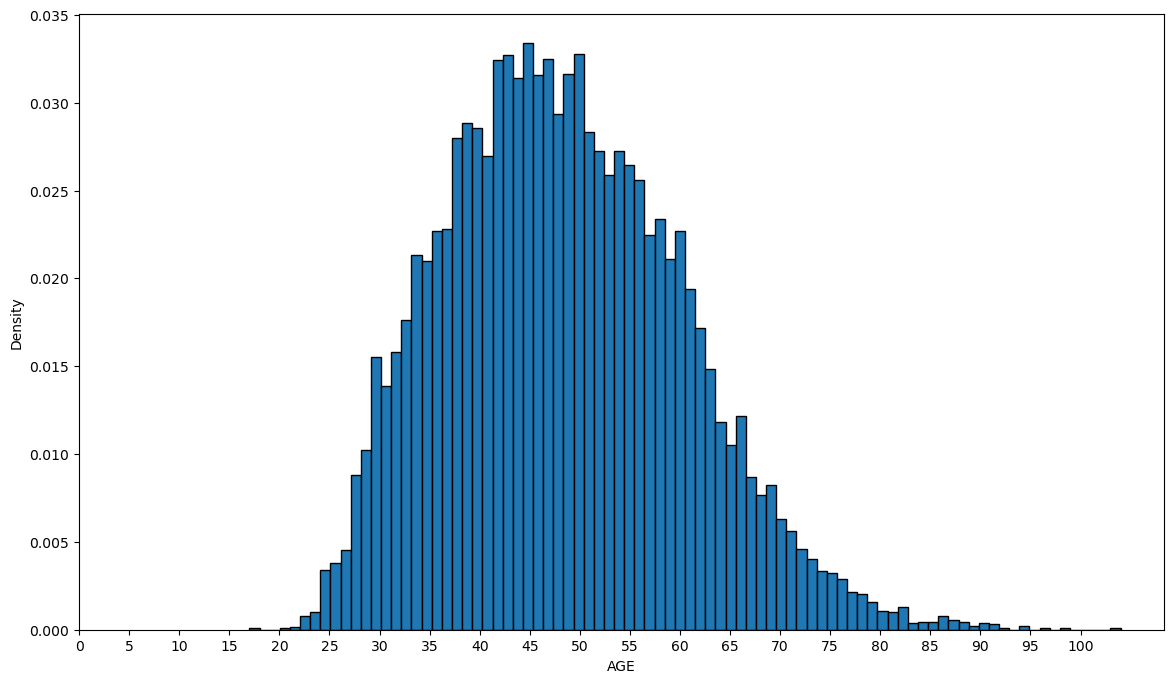

In [17]:
#--------------------------------------------------------------------------------------------------------
# Plotting
#--------------------------------------------------------------------------------------------------------
plt.figure(figsize=(14, 8))
plt.hist(magist_buroc_no_invalid_RFC_6s['AGE'], bins=86, edgecolor='black', density=True)
plt.xticks(range(0, int(max(magist_buroc_no_invalid_RFC_6s['AGE'])) + 1, 5))
plt.xlabel('AGE')
plt.ylabel('Density')


plt.show()

## Create GENDER column for Population Pyramid

In [18]:
magist_buroc_no_invalid_RFC_6s['GENDER'] = magist_buroc_no_invalid_RFC_6s['CURP'].str[10]

## Dealing with rows where GENDER is invalid 

In [19]:
#--------------------------------------------------------------------------------------------------------
#Checking for rows where GENDER is different from H or M 
#--------------------------------------------------------------------------------------------------------
df_invalid_gender = magist_buroc_no_invalid_RFC_6s[(magist_buroc_no_invalid_RFC_6s['GENDER'] != 'H') & (magist_buroc_no_invalid_RFC_6s['GENDER'] != 'M')].sort_values(by='NOMBRE_correct_final')
print(f'Invalid GENDER: {df_invalid_gender.shape[0]} rows of {magist_buroc_no_invalid_RFC_6s.shape[0]}: {df_invalid_gender.shape[0]/magist_buroc_no_invalid_RFC_6s.shape[0] * 100} %')
#--------------------------------------------------------------------------------------------------------
#Dropping invalid rows
#--------------------------------------------------------------------------------------------------------
magist_buroc_concat_no_duplicates_no_invalid_gender = magist_buroc_no_invalid_RFC_6s[~magist_buroc_no_invalid_RFC_6s['RFC'].isin(df_invalid_gender['RFC'])]
print('We drop these rows since it is < 5%')
# print(magist_buroc_concat_no_duplicates_no_invalid[(magist_buroc_concat_no_duplicates_no_invalid['GENDER'] != 'H') & (magist_buroc_concat_no_duplicates_no_invalid['GENDER'] != 'M')].sort_values(by='NOMBRE_correct_final'))

Invalid GENDER: 523 rows of 13051: 4.0073557581794494 %
We drop these rows since it is < 5%


## Create Plot

C:\Users\rodri\AppData\Local\Temp\ipykernel_13508\2102295370.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  magist_buroc_concat_no_duplicates_no_invalid_gender['AGE_CATEGORY'] = np.select(conditions, age_categories)
C:\Users\rodri\AppData\Local\Temp\ipykernel_13508\2102295370.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  magist_buroc_concat_pyramid_pop = magist_buroc_concat_pyramid_pop.append(new_row, ignore_index=True)


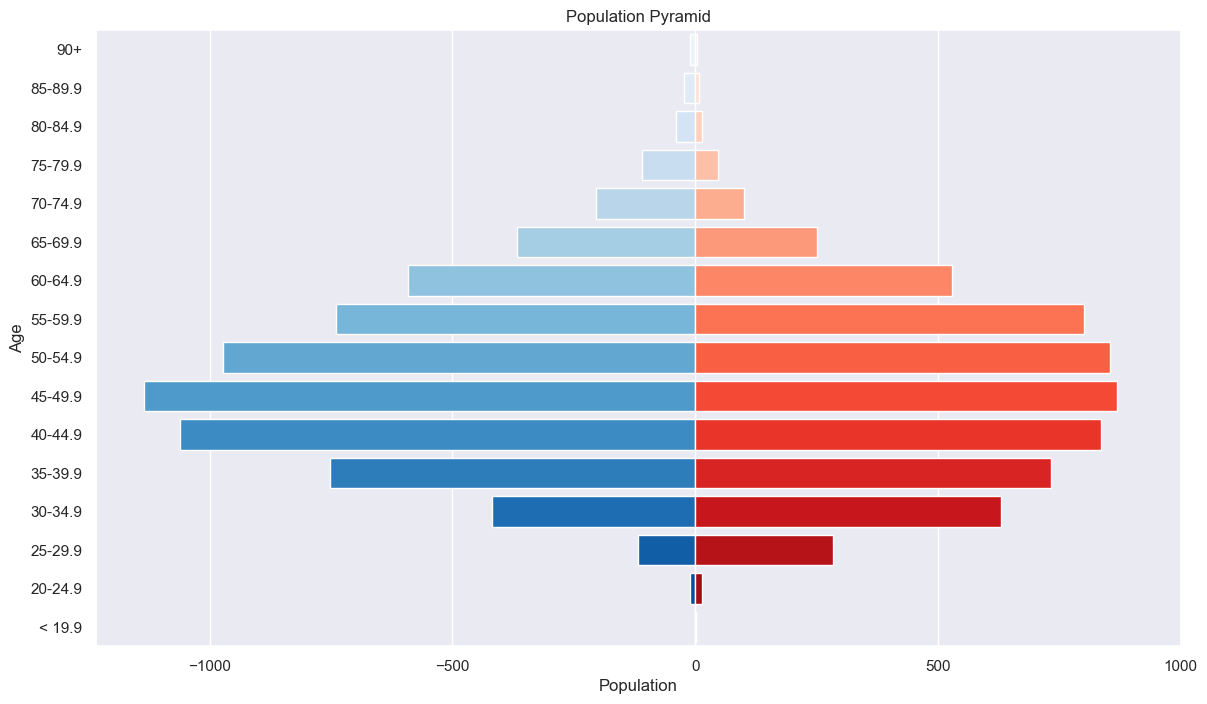

In [20]:
#--------------------------------------------------------------------------------------------------------
#Creating the age categories 
#--------------------------------------------------------------------------------------------------------
age_categories = []
age_categories.append('< 19.9')
for start in range(20, 100, 5):
    end = start + 4.9
    if start >= 90:
        age_categories.append('90+')
        break
    age_categories.append(f'{start:.0f}-{end:.1f}')
    

conditions = []
conditions.append(magist_buroc_concat_no_duplicates_no_invalid_gender['AGE'] <= 19.9)
for start in range(20, 90, 5):
    end = start + 4.9
    condition = (
        (magist_buroc_concat_no_duplicates_no_invalid_gender['AGE'] >= start) &
        (magist_buroc_concat_no_duplicates_no_invalid_gender['AGE'] <= end)
    )
    conditions.append(condition)

conditions.append(magist_buroc_concat_no_duplicates_no_invalid_gender['AGE'] >= 90)
magist_buroc_concat_no_duplicates_no_invalid_gender['AGE_CATEGORY'] = np.select(conditions, age_categories)
magist_buroc_concat_no_duplicates_no_invalid_gender[['AGE', 'AGE_CATEGORY']]
#--------------------------------------------------------------------------------------------------------
#Editing index and rows for plotting graph
#--------------------------------------------------------------------------------------------------------
magist_buroc_concat_pyramid_pop = magist_buroc_concat_no_duplicates_no_invalid_gender.value_counts(subset=['AGE_CATEGORY', 'GENDER']).sort_index().reset_index(name='POPULATION')
desired_row_index = 30
desired_row = magist_buroc_concat_pyramid_pop.loc[desired_row_index]
# Drop the desired row from its original position
magist_buroc_concat_pyramid_pop = magist_buroc_concat_pyramid_pop.drop(desired_row_index)
# Reinsert the desired row at the beginning
magist_buroc_concat_pyramid_pop = pd.concat([desired_row.to_frame().T, magist_buroc_concat_pyramid_pop], ignore_index=True)
new_row = {'AGE_CATEGORY': '< 19.9', 'GENDER': 'H', 'POPULATION': 0}
# Index where you want to add the row
index_to_add = 0
# Insert the new row at the specified index using loc
magist_buroc_concat_pyramid_pop = magist_buroc_concat_pyramid_pop.append(new_row, ignore_index=True)
magist_buroc_concat_pyramid_pop = pd.concat([magist_buroc_concat_pyramid_pop.iloc[:index_to_add], pd.DataFrame([new_row]), magist_buroc_concat_pyramid_pop.iloc[index_to_add:]]).reset_index(drop=True).drop(index=32)
#--------------------------------------------------------------------------------------------------------
#Creating two separate DataFrames (one for male, one for female)
#--------------------------------------------------------------------------------------------------------
magist_buroc_concat_pyramid_pop_male = magist_buroc_concat_pyramid_pop[magist_buroc_concat_pyramid_pop['GENDER'] == 'H']
magist_buroc_concat_pyramid_pop_female = magist_buroc_concat_pyramid_pop[magist_buroc_concat_pyramid_pop['GENDER'] == 'M']

magist_buroc_concat_pyramid_pop_formatted = magist_buroc_concat_pyramid_pop_male.merge(magist_buroc_concat_pyramid_pop_female, on='AGE_CATEGORY', how='inner', suffixes=['_male', '_female']).drop(columns=['GENDER_male', 'GENDER_female'])
magist_buroc_concat_pyramid_pop_formatted['POPULATION_male'] = (-1)*magist_buroc_concat_pyramid_pop_formatted['POPULATION_male']
#--------------------------------------------------------------------------------------------------------
#Plotting
#--------------------------------------------------------------------------------------------------------
sns.set(rc={"figure.figsize": (14, 8)})
sns.color_palette('bright')
bar_plot = sns.barplot(x='POPULATION_male', y='AGE_CATEGORY', data=magist_buroc_concat_pyramid_pop_formatted.iloc[::-1], palette='Blues', saturation=1)
bar_plot = sns.barplot(x='POPULATION_female', y='AGE_CATEGORY', data=magist_buroc_concat_pyramid_pop_formatted[::-1], palette='Reds', saturation=1)
bar_plot.set(xlabel="Population", ylabel="Age", title = "Population Pyramid")
bar_plot.set_xticks([-1000, -500, 0, 500, 1000])
#--------------------------------------------------------------------------------------------------------
plt.show()

# Building the SALARIES PLOT

## Summing relevant payment columns to create TOTAL_SALARY column

In [21]:
for i in range(18,102):
    magist_12_16_copy.iloc[:, i] = magist_12_16_copy.iloc[:, i].astype('float')
print(magist_12_16_copy.info())

for i in range(24,160):
    magist_17_22_copy.iloc[:, i] = magist_17_22_copy.iloc[:, i].astype('float')
print(magist_17_22_copy.info())

for i in range(14,149):
    buroc_12_22_copy.iloc[:, i] = buroc_12_22_copy.iloc[:, i].astype('float')
print(buroc_12_22_copy.info())


magist_12_16_percepciones_cols = magist_12_16_copy.columns[18:66]
# print(magist_12_16_percepciones_cols)
magist_12_16_deduciones_cols = magist_12_16_copy.columns[66:102]
# print(magist_12_16_deduciones_cols)
magist_12_16_copy['TOTAL_SALARY'] = magist_12_16_copy[magist_12_16_percepciones_cols].sum(axis=1) 

magist_17_22_percepciones_cols = magist_17_22_copy.columns[24:116]
# print(magist_17_22_percepciones_cols)
magist_17_22_deduciones_cols = magist_17_22_copy.columns[116:160]
# print(magist_17_22_deduciones_cols)
magist_17_22_copy['TOTAL_SALARY'] = magist_17_22_copy[magist_17_22_percepciones_cols].sum(axis=1)

buroc_12_22_percepciones_cols = buroc_12_22_copy.columns[14:82]
# print(buroc_12_22_percepciones_cols)
buroc_12_22_deduciones_cols = buroc_12_22_copy.columns[82:149]
# print(buroc_12_22_deduciones_cols)
buroc_12_22_copy['TOTAL_SALARY'] = buroc_12_22_copy[buroc_12_22_percepciones_cols].sum(axis=1)

C:\Users\rodri\AppData\Local\Temp\ipykernel_13508\4092160520.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  magist_12_16_copy.iloc[:, i] = magist_12_16_copy.iloc[:, i].astype('float')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78248 entries, 0 to 78247
Columns: 107 entries, NOMINA to NOMBRE_correct_final
dtypes: float64(84), object(23)
memory usage: 63.9+ MB
None


C:\Users\rodri\AppData\Local\Temp\ipykernel_13508\4092160520.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  magist_17_22_copy.iloc[:, i] = magist_17_22_copy.iloc[:, i].astype('float')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113814 entries, 0 to 113813
Columns: 165 entries, NOMINA to NOMBRE_correct_final
dtypes: float64(136), object(29)
memory usage: 143.3+ MB
None


C:\Users\rodri\AppData\Local\Temp\ipykernel_13508\4092160520.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  buroc_12_22_copy.iloc[:, i] = buroc_12_22_copy.iloc[:, i].astype('float')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16774 entries, 0 to 16773
Columns: 154 entries, NOMINA to NOMBRE_correct_final
dtypes: float64(135), object(19)
memory usage: 19.7+ MB
None


## Creating concatenated DataFrame

In [22]:
# magist_17_22_copy[['NOMBRE_correct_final', 'CICLO', 'CICLOEXT', 'NOMBRAM', 'UR', 'DESPARTIDA', 'AREA']].head(5000).sort_values(by=['NOMBRAM'])

magist_buroc_salary_concat = pd.concat([magist_12_16_copy[['NOMBRE_correct_final', 'AÑO', 'CICLO', 'CICLOEXT', 'RFC_10', 'TOTAL_SALARY']], magist_17_22_copy[['NOMBRE_correct_final', 'AÑO', 'CICLO', 'CICLOEXT', 'RFC_10', 'TOTAL_SALARY']], buroc_12_22_copy[['NOMBRE_correct_final', 'AÑO', 'CICLO', 'CICLOEXT', 'RFC_10', 'TOTAL_SALARY']]], keys=['magist_12_16', 'magist_17_22', 'buroc_12_22'])

## Creating CICLO_DATE column

In [23]:
ciclo_to_month_mapping = {'1': 'january', '2':'january', '3': 'february' , '4': 'february', '5': 'march', '6': 'march', '7': 'april', '8': 'april', '9': 'may', '10': 'may', '11': 'june','12':'june', '13':'july', '14':'july', '15':'august', '16':'august', '17':'september', '18':'september', '19':'october', '20':'october', '21':'november', '22':'november', '23':'december', '24':'december'}

magist_buroc_salary_concat['CICLO_MONTH'] = magist_buroc_salary_concat['CICLO'].map(ciclo_to_month_mapping)
magist_buroc_salary_concat['CICLO_DATE'] = magist_buroc_salary_concat['AÑO'] + '-' + magist_buroc_salary_concat['CICLO_MONTH'] + '-01'
magist_buroc_salary_concat.loc[:, 'CICLO_DATE'] = pd.to_datetime(magist_buroc_salary_concat['CICLO_DATE'])

C:\Users\rodri\AppData\Local\Temp\ipykernel_13508\1795855331.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  magist_buroc_salary_concat.loc[:, 'CICLO_DATE'] = pd.to_datetime(magist_buroc_salary_concat['CICLO_DATE'])


## Getting num of unique RFC_10s and TOTAL_SALARY for each date of CICLO_DATE

In [24]:
df_for_plotting = magist_buroc_salary_concat.groupby(['CICLO_DATE'])['RFC_10'].nunique().reset_index().merge(magist_buroc_salary_concat.groupby('CICLO_DATE')['TOTAL_SALARY'].sum(), on='CICLO_DATE')
print(df_for_plotting)

   CICLO_DATE  RFC_10  TOTAL_SALARY
0  2012-03-01    7628  3.217838e+08
1  2012-05-01    2098  3.791519e+07
2  2012-09-01    3566  6.471696e+07
3  2013-05-01    2096  4.464332e+07
4  2013-09-01    2171  4.123677e+07
5  2014-05-01    2039  4.298440e+07
6  2014-09-01    2078  2.691866e+07
7  2015-05-01    2088  4.643101e+07
8  2015-09-01    2048  2.569181e+07
9  2016-05-01    2092  4.710576e+07
10 2016-09-01    1924  3.028564e+07
11 2017-05-01    3149  8.478911e+07
12 2017-09-01    2942  5.243426e+07
13 2018-05-01    3186  9.108837e+07
14 2018-09-01    3060  7.131600e+07
15 2019-05-01    3307  8.893455e+07
16 2019-09-01    3049  7.052028e+07
17 2020-05-01    3288  9.695617e+07
18 2020-09-01    3054  6.509010e+07
19 2021-05-01    3306  9.854029e+07
20 2021-09-01    3134  6.745733e+07
21 2022-05-01    3248  1.011022e+08
22 2022-09-01    2991  4.187749e+07


## Create Plot

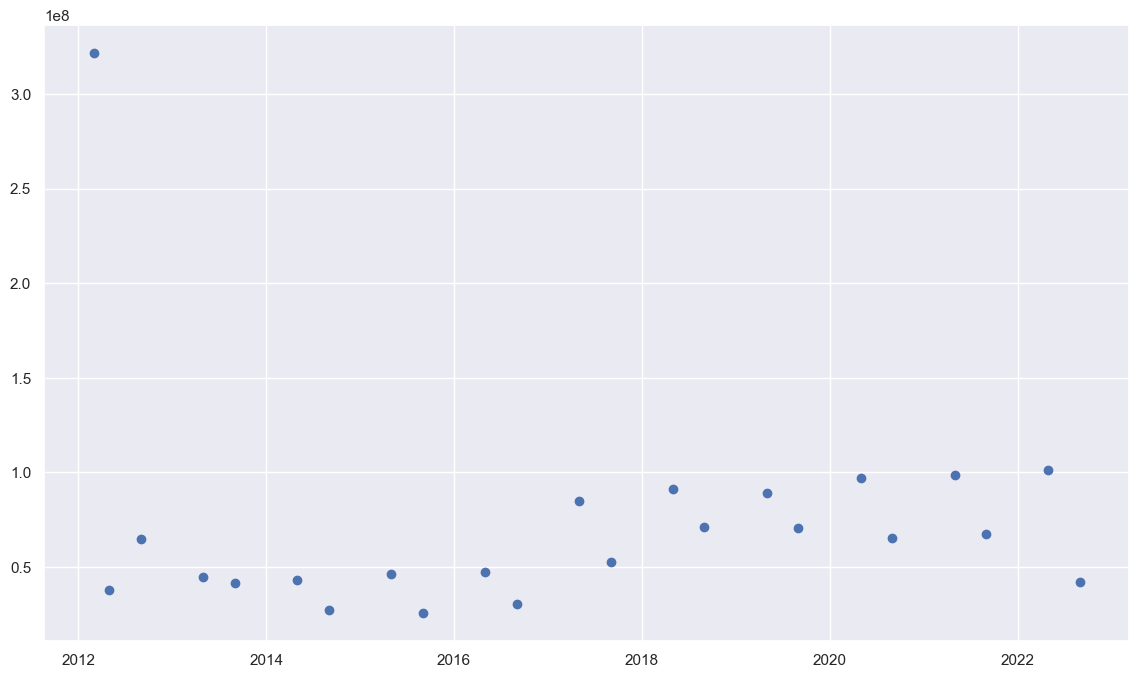

In [25]:
plt.figure(figsize = (14,8))
plt.plot(df_for_plotting['CICLO_DATE'], df_for_plotting['TOTAL_SALARY'], 'o')